In [12]:
from seagul.rl.ars.ars_pipe import ars
from seagul.nn import MLP
import torch
import matplotlib.pyplot as plt
from seagul.mesh import variation_dim
import time
import copy
import gym

import xarray as xr 
import pandas as pd
import numpy as np

def identity(rews,obs,acts):
    return rews

def shrinkdim(rews, obs, acts):
    return rews/variation_dim(obs)

def growdim(rews, obs, acts):
    return rews*variation_dim(obs)

def rough_measure(x):
    d = torch.stack([x[t,:] - x[t-1,:] for t in range(1,x.shape[0])])
    return d.std()#$/(torch.abs(d.mean()))

def rmul(rews, obs, acts):
    return rews*rough_measure(obs)

def rdiv(rews, obs, acts):
    return rews/rough_measure(obs)


def vardiv(rews, obs, acts):
    return rews/variation_dim(obs)


exp_names = ['standard', 'rmul']
exp_fns = [identity, rmul]

def do_rollout(env, policy, render=False):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while not done:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())
        if render:
            env.render()
            time.sleep(.02)

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length, None

/home/sgillen/miniconda3/envs/baselines/lib/python3.6/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/sgillen/miniconda3/envs/baselines/lib/python3.6/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Text(0.5, 1.0, 'Reward')

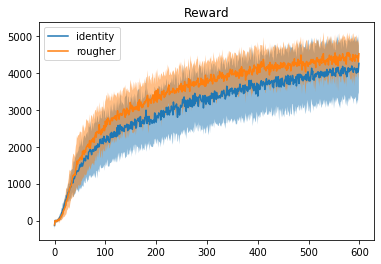

In [6]:
#exp_names = ['standard','vardiv','varmul','rmul','rdiv']
#exp_fns = [identity, shrinkdim, growdim, rmul, rdiv]
env_name = "HalfCheetah-v2"

name="mjhc_longermul"
policy_dict = torch.load("./data/" + name + ".pol_dict")
data = torch.load("./data/" + name +".data")
data_post = torch.load("./data/" + name + ".post_data")


means = data.mean(dim="Trial")
stds = data.std(dim="Trial")

plt.plot(means.T)
plt.legend(['identity', 'rougher'])
ci = stds

for mean, c in zip(means, ci):
    plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
plt.title("Reward")

# plt.figure()
# means = data_post.mean(dim="Trial")
# stds = data_post.std(dim="Trial")

# plt.plot(means.T)
# plt.legend(['identity', 'rougher'])
# ci = stds

# for mean, c in zip(means, ci):
#     plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
# plt.title("Post Processed")
# plt.figure()
    
# for exp_name in exp_names:  
#     plt.plot(data.loc[exp_name].T)
#     plt.title(exp_name)
#     plt.figure()

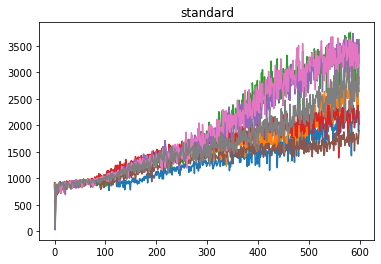

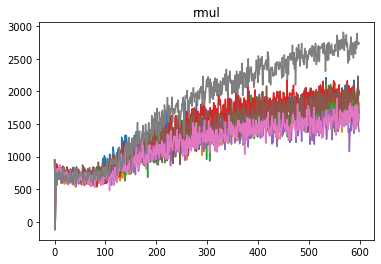

<Figure size 432x288 with 0 Axes>

/home/sgillen/miniconda3/envs/baselines/lib/python3.6/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/sgillen/miniconda3/envs/baselines/lib/python3.6/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


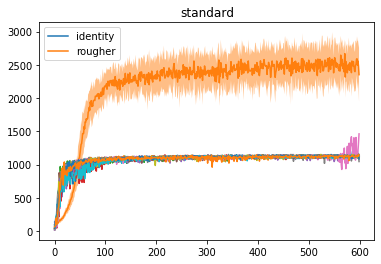

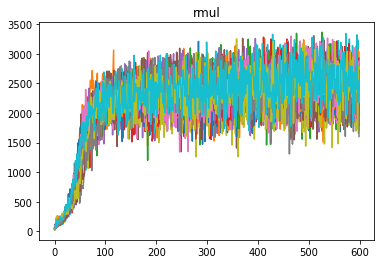

<Figure size 432x288 with 0 Axes>

In [10]:
#exp_names = ['standard','vardiv','varmul','rmul','rdiv']
#exp_fns = [identity, shrinkdim, growdim, rmul, rdiv]
env_name = "Hopper-v2"

name="mjhp0"
policy_dict = torch.load("./data/" + name + ".pol_dict")
data = torch.load("./data/" + name +".data")
data_post = torch.load("./data/" + name + ".post_data")

means = data.mean(dim="Trial")
stds = data.std(dim="Trial")

plt.plot(means.T)
plt.legend(['identity', 'rougher'])
ci = stds

for mean, c in zip(means, ci):
    plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
plt.title("Reward")

# plt.figure()
# means = data_post.mean(dim="Trial")
# stds = data_post.std(dim="Trial")

# plt.plot(means.T)
# plt.legend(['identity', 'rougher'])
# ci = stds

# for mean, c in zip(means, ci):
#     plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
# plt.title("Post Processed")
# plt.figure()
    
for exp_name in exp_names:  
    plt.plot(data.loc[exp_name].T)
    plt.title(exp_name)
    plt.figure()

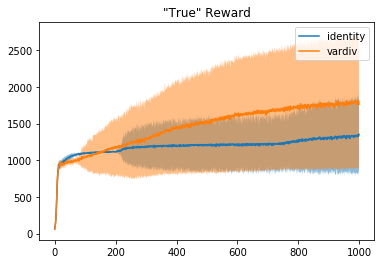

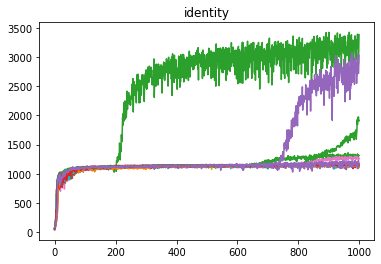

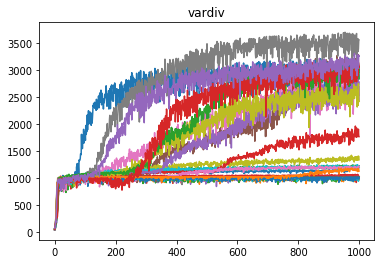

<Figure size 432x288 with 0 Axes>

In [13]:
data = torch.load("./data5/Hopper-v2.xr")

policy_dict = data.policy_dict
rews = data.rews
exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
num_seeds = len(policy_dict['identity'])

#policy_dict = torch.load("./data/mjw_longermul.pol_dict")
#rews = torch.load("./data/mjw_longermul.data")

means = rews.mean(dim="trial")
stds = rews.std(dim="trial")

plt.plot(means.T)
plt.legend(exp_names)
ci = stds

for mean, c in zip(means, ci):
    plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
plt.title("\"True\" Reward")
plt.figure()

for exp_name in exp_names:  
    plt.plot(rews.loc[exp_name].T)
    plt.title(exp_name)
    plt.figure()

/home/sgillen/miniconda3/envs/baselines/lib/python3.6/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/sgillen/miniconda3/envs/baselines/lib/python3.6/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Text(0.5, 1.0, 'Reward')

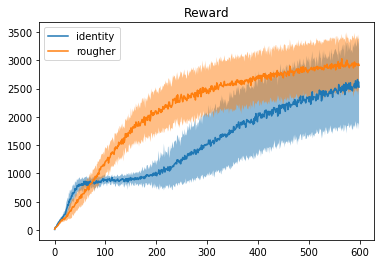

In [9]:
#exp_names = ['standard','vardiv','varmul','rmul','rdiv']
#exp_fns = [identity, shrinkdim, growdim, rmul, rdiv]
env_name = "Walker2d-v2"

name="mjw_longermul"
policy_dict = torch.load("./data/" + name + ".pol_dict")
data = torch.load("./data/" + name +".data")
data_post = torch.load("./data/" + name + ".post_data")

means = data.mean(dim="Trial")
stds = data.std(dim="Trial")

plt.plot(means.T)
plt.legend(['identity', 'rougher'])
ci = stds

for mean, c in zip(means, ci):
    plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
plt.title("Reward")

# plt.figure()
# means = data_post.mean(dim="Trial")
# stds = data_post.std(dim="Trial")

# plt.plot(means.T)
# plt.legend(['identity', 'rougher'])
# ci = stds

# for mean, c in zip(means, ci):
#     plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
# plt.title("Post Processed")
# plt.figure()
    
# for exp_name in exp_names:  
#     plt.plot(data.loc[exp_name].T)
#     plt.title(exp_name)
#     plt.figure()

In [118]:
import gym
import pybullet_envs
env = gym.make(env_name)

In [124]:
post_name = "standard"; seed = 0
o,a,r,l,_ = do_rollout(env,policy_dict[post_name][seed], render=True)

print("reward:", sum(r))
print("variation_dim: ", variation_dim(o))
print("roughness: ", rough_measure(o))
plt.plot(o)
plt.figure()
plt.plot(a)

#import scipy.io 
#import os

#os.makedirs(f"./data/j/{name}/{exp_name}/{seed}", exist_ok=True)
#scipy.io.savemat(f"./data/j/{name}/{exp_name}/{seed}/{run}.mat", mdict = {"obs":o, "act":a, "rew":r})

KeyboardInterrupt: 

In [125]:
for post_name in ['standard' ,'rmul']: #seed = 10
    for run in [0,1,2,3,4]:
        o,a,r,l,_ = do_rollout(env,policy_dict[post_name][seed])

        #print("reward:", sum(r))
        #print("variation_dim: ", variation_dim(o))
        #print("roughness: ", rough_measure(o))
        #plt.plot(o)
        #plt.figure()
        #plt.plot(a)

        import scipy.io 
        import os

        o = np.array(o)
        a = np.array(a)
        r = np.array(r)
        os.makedirs(f"./j/exp_{name}/post_{post_name}/seed_{seed}", exist_ok=True)
        scipy.io.savemat(f"./j/exp_{name}/post_{post_name}/seed_{seed}/run_{run}.mat", mdict = {"obs":o, "act":a, "rew":r})

In [46]:
env.close()